In [1]:
import sys
sys.path.insert(0, '..')
import functools
import timeit
import zarr
print('zarr', zarr.__version__)
from zarr import blosc
print('blosc', blosc.version())
import numpy as np
import h5py
%matplotlib inline
import matplotlib.pyplot as plt

zarr 1.1.1.dev7+dirty
blosc ('1.10.0.dev', '$Date:: 2016-07-20 #$')


In [2]:
callset = h5py.File('/data/coluzzi/ag1000g/data/phase1/release/AR3/variation/main/hdf5/ag1000g.phase1.ar3.pass.h5',
                    mode='r')
genotype = callset['3R/calldata/genotype']
genotype

<HDF5 dataset "genotype": shape (13167162, 765, 2), type "|i1">

In [3]:
n_variants = 500000

In [4]:
genotype_sample = genotype[1000000:1000000+n_variants, ...]
genotype_sample.shape

(500000, 765, 2)

In [5]:
nbytes = genotype_sample.nbytes
nbytes

765000000

In [6]:
# 1M chunks of first dimension
chunks = (int(2**20 / (genotype_sample.shape[1] * genotype_sample.shape[2])), 
          genotype_sample.shape[1], 
          genotype_sample.shape[2])
chunks

(685, 765, 2)

In [7]:
blosc.get_nthreads()

8

In [8]:
zarr.array(genotype_sample, chunks=chunks, compression_opts=dict(cname='lz4', clevel=1, shuffle=2))

zarr.core.Array((500000, 765, 2), int8, chunks=(685, 765, 2), order=C)
  compression: blosc; compression_opts: {'cname': 'lz4', 'clevel': 1, 'shuffle': 2}
  nbytes: 729.6M; nbytes_stored: 23.0M; ratio: 31.7; initialized: 730/730
  store: builtins.dict

In [9]:
zarr.array(genotype_sample, chunks=chunks, compression_opts=dict(cname='zstd', clevel=1, shuffle=2))

zarr.core.Array((500000, 765, 2), int8, chunks=(685, 765, 2), order=C)
  compression: blosc; compression_opts: {'cname': 'zstd', 'clevel': 1, 'shuffle': 2}
  nbytes: 729.6M; nbytes_stored: 12.0M; ratio: 60.7; initialized: 730/730
  store: builtins.dict

In [38]:
compression_configs = (
    (None, None),
    ('zlib', 1),
    ('bz2', 1),
    ('lzma', dict(preset=1)),
    ('blosc', dict(cname='snappy', clevel=0, shuffle=0)),
    ('blosc', dict(cname='snappy', clevel=0, shuffle=2)),
    ('blosc', dict(cname='snappy', clevel=9, shuffle=0)),
    ('blosc', dict(cname='snappy', clevel=9, shuffle=2)),
    ('blosc', dict(cname='blosclz', clevel=1, shuffle=0)),
    ('blosc', dict(cname='blosclz', clevel=1, shuffle=2)),
    ('blosc', dict(cname='blosclz', clevel=5, shuffle=0)),
    ('blosc', dict(cname='blosclz', clevel=5, shuffle=2)),
    ('blosc', dict(cname='blosclz', clevel=9, shuffle=0)),
    ('blosc', dict(cname='blosclz', clevel=9, shuffle=2)),
    ('blosc', dict(cname='lz4', clevel=1, shuffle=0)),
    ('blosc', dict(cname='lz4', clevel=1, shuffle=2)),
    ('blosc', dict(cname='lz4', clevel=5, shuffle=0)),
    ('blosc', dict(cname='lz4', clevel=5, shuffle=2)),
    ('blosc', dict(cname='lz4', clevel=9, shuffle=0)),
    ('blosc', dict(cname='lz4', clevel=9, shuffle=2)),
    ('blosc', dict(cname='lz4hc', clevel=1, shuffle=0)),
    ('blosc', dict(cname='lz4hc', clevel=1, shuffle=2)),
    ('blosc', dict(cname='lz4hc', clevel=3, shuffle=0)),
    ('blosc', dict(cname='lz4hc', clevel=3, shuffle=2)),
    ('blosc', dict(cname='zstd', clevel=1, shuffle=0)),
    ('blosc', dict(cname='zstd', clevel=1, shuffle=2)),
    ('blosc', dict(cname='zstd', clevel=3, shuffle=0)),
    ('blosc', dict(cname='zstd', clevel=3, shuffle=2)),
    ('blosc', dict(cname='zstd', clevel=5, shuffle=0)),
    ('blosc', dict(cname='zstd', clevel=5, shuffle=2)),
    ('blosc', dict(cname='zlib', clevel=1, shuffle=0)),
    ('blosc', dict(cname='zlib', clevel=1, shuffle=2)),
    ('blosc', dict(cname='zlib', clevel=3, shuffle=0)),
    ('blosc', dict(cname='zlib', clevel=3, shuffle=2)),
    ('blosc', dict(cname='zlib', clevel=5, shuffle=0)),
    ('blosc', dict(cname='zlib', clevel=5, shuffle=2)),
)

In [39]:
def log(*msg):
    print(*msg, file=sys.stdout)
    sys.stdout.flush()

In [40]:
@functools.lru_cache(maxsize=None)
def compression_ratios():
    x = list()
    for compression, compression_opts in compression_configs:
        z = zarr.array(genotype_sample, chunks=chunks, compression=compression, 
                       compression_opts=compression_opts)
        ratio = z.nbytes / z.nbytes_stored
        x.append(ratio)
        log(compression, compression_opts, ratio)
    return x


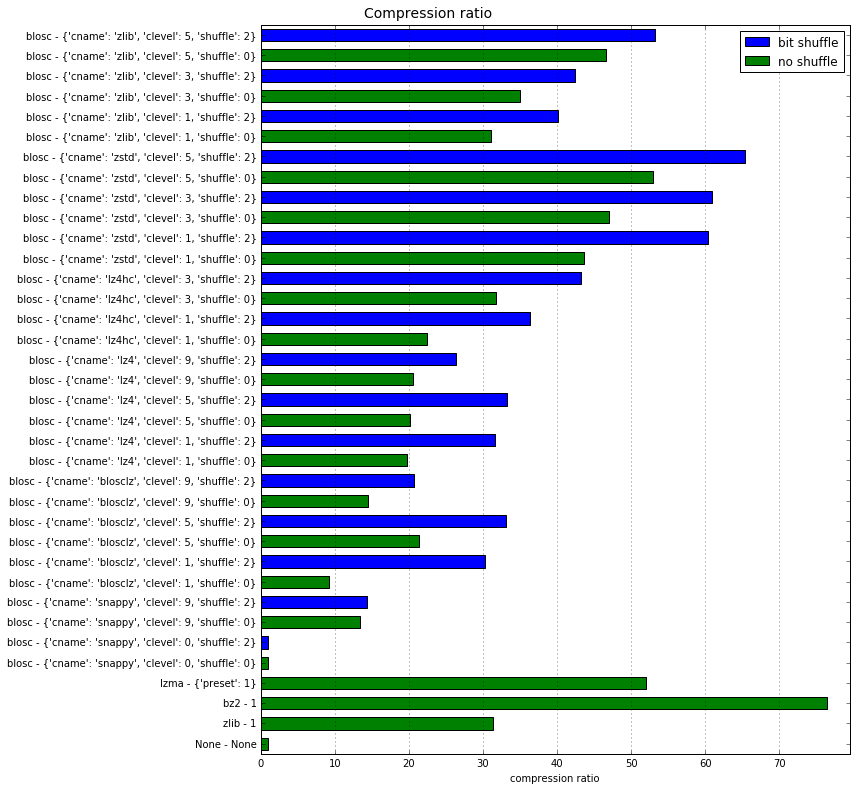

In [43]:
ratios = compression_ratios()    
labels = ['%s - %s' % (c, o)
          for c, o in compression_configs]

fig = plt.figure(figsize=(12, len(compression_configs)*.3))
fig.suptitle('Compression ratio', fontsize=14, y=1.01)
ax = fig.add_subplot(1, 1, 1)

y = [i for i, (c, o) in enumerate(compression_configs) if c == 'blosc' and o['shuffle'] == 2]
x = [ratios[i] for i in y]
ax.barh(bottom=np.array(y)+.2, width=np.array(x), height=.6, label='bit shuffle', color='b')

y = [i for i, (c, o) in enumerate(compression_configs) if c != 'blosc' or o['shuffle'] == 0]
x = [ratios[i] for i in y]
ax.barh(bottom=np.array(y)+.2, width=np.array(x), height=.6, label='no shuffle', color='g')

ax.set_yticks(np.arange(len(labels))+.5)
ax.set_yticklabels(labels, rotation=0)

ax.set_xlim(0, max(ratios)+3)
ax.set_ylim(0, len(ratios))
ax.set_xlabel('compression ratio')
ax.grid(axis='x')
ax.legend(loc='upper right')

fig.tight_layout();


In [56]:
@functools.lru_cache(maxsize=None)
def compression_decompression_times(repeat=3, number=1):
    c = list()
    d = list()
    for compression, compression_opts in compression_configs:
        
        def compress():
            zarr.array(genotype_sample, chunks=chunks, compression=compression, 
                       compression_opts=compression_opts)
            
        t = timeit.Timer(stmt=compress, globals=locals())
        compress_times = t.repeat(repeat=repeat, number=number)
        c.append(compress_times)
        
        z = zarr.array(genotype_sample, chunks=chunks, compression=compression, 
                       compression_opts=compression_opts)
        
        def decompress():
            z[:]
            
        t = timeit.Timer(stmt=decompress, globals=locals())
        decompress_times = t.repeat(repeat=repeat, number=number)
        d.append(decompress_times)
        
        log(compression, compression_opts, compress_times, decompress_times)
        
    return c, d
    

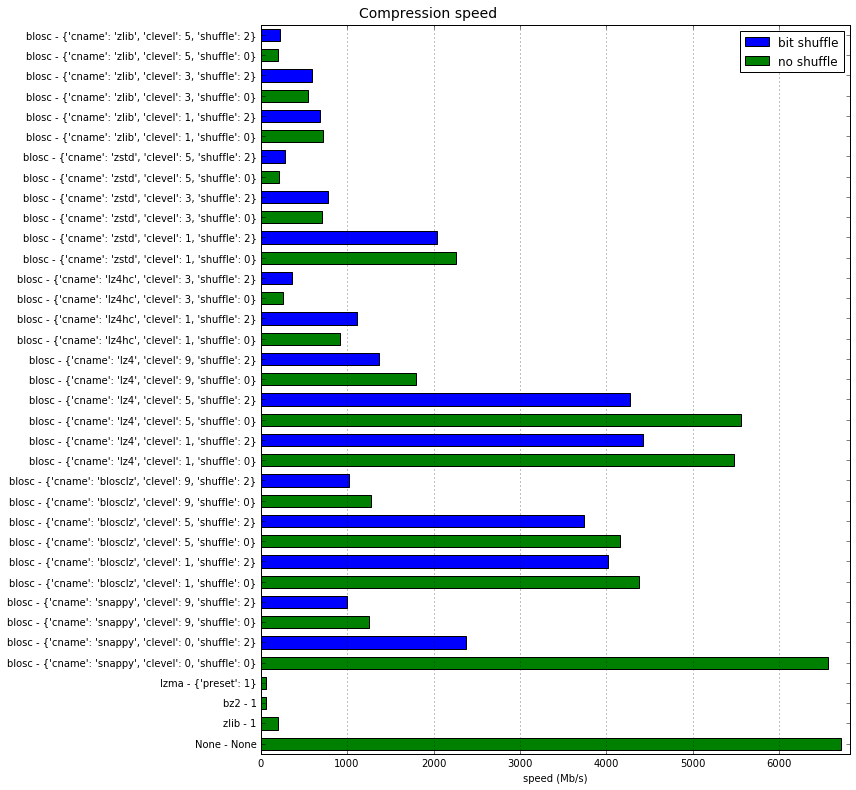

In [59]:
co_t, de_t = compression_decompression_times()

fig = plt.figure(figsize=(12, len(compression_configs)*.3))
fig.suptitle('Compression speed', fontsize=14, y=1.01)


ax = fig.add_subplot(1, 1, 1)

y = [i for i, (c, o) in enumerate(compression_configs) if c == 'blosc' and o['shuffle'] == 2]
x = (nbytes / 1000000) / np.array([co_t[i] for i in y])
ax.barh(bottom=np.array(y)+.2, width=x.max(axis=1), height=.6, label='bit shuffle', color='b')

y = [i for i, (c, o) in enumerate(compression_configs) if c != 'blosc' or o['shuffle'] == 0]
x = (nbytes / 1000000) / np.array([co_t[i] for i in y])
ax.barh(bottom=np.array(y)+.2, width=x.max(axis=1), height=.6, label='no shuffle', color='g')

ax.set_yticks(np.arange(len(labels))+.5)
ax.set_yticklabels(labels, rotation=0)

xlim = (0, np.max((nbytes / 1000000) / np.array(co_t)) + 100)
ax.set_xlim(*xlim)
ax.set_ylim(0, len(co_t))
ax.set_xlabel('speed (Mb/s)')
ax.grid(axis='x')
ax.legend(loc='upper right')

fig.tight_layout();

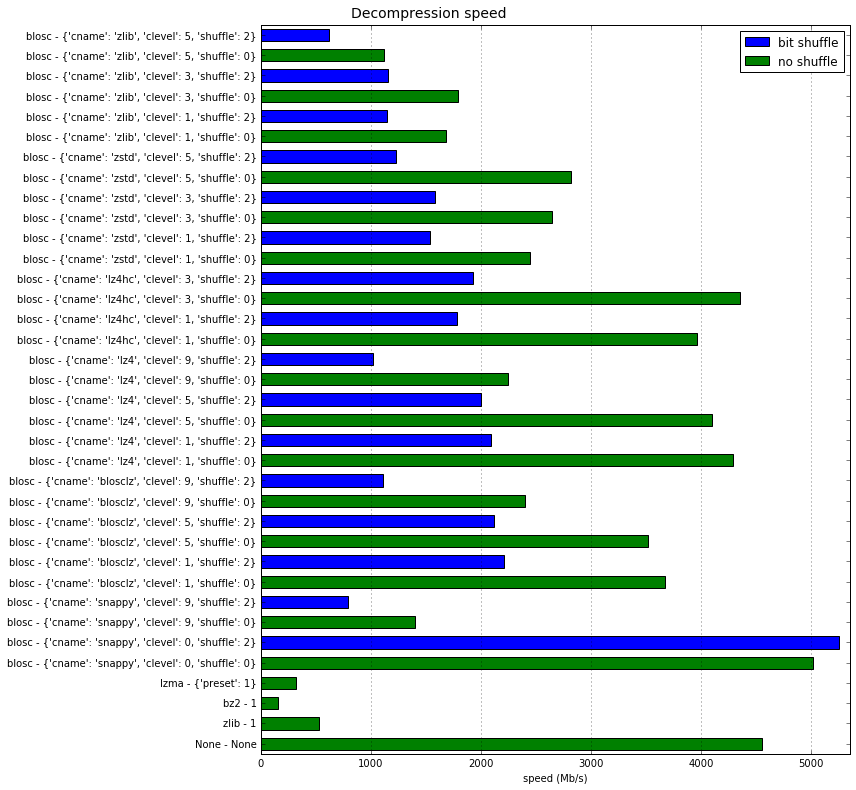

In [60]:
co_t, de_t = compression_decompression_times()

fig = plt.figure(figsize=(12, len(compression_configs)*.3))
fig.suptitle('Decompression speed', fontsize=14, y=1.01)


ax = fig.add_subplot(1, 1, 1)

y = [i for i, (c, o) in enumerate(compression_configs) if c == 'blosc' and o['shuffle'] == 2]
x = (nbytes / 1000000) / np.array([de_t[i] for i in y])
ax.barh(bottom=np.array(y)+.2, width=x.max(axis=1), height=.6, label='bit shuffle', color='b')

y = [i for i, (c, o) in enumerate(compression_configs) if c != 'blosc' or o['shuffle'] == 0]
x = (nbytes / 1000000) / np.array([de_t[i] for i in y])
ax.barh(bottom=np.array(y)+.2, width=x.max(axis=1), height=.6, label='no shuffle', color='g')

ax.set_yticks(np.arange(len(labels))+.5)
ax.set_yticklabels(labels, rotation=0)

xlim = (0, np.max((nbytes / 1000000) / np.array(de_t)) + 100)
ax.set_xlim(*xlim)
ax.set_ylim(0, len(de_t))
ax.set_xlabel('speed (Mb/s)')
ax.grid(axis='x')
ax.legend(loc='upper right')

fig.tight_layout();

In [61]:
import cpuinfo

In [63]:
cpuinfo.main()

Vendor ID: GenuineIntel
Hardware Raw: 
Brand: Intel(R) Xeon(R) CPU E3-1505M v5 @ 2.80GHz
Hz Advertised: 2.8000 GHz
Hz Actual: 1.1000 GHz
Hz Advertised Raw: (2800000000, 0)
Hz Actual Raw: (1100000000, 0)
Arch: X86_64
Bits: 64
Count: 8
Raw Arch String: x86_64
L2 Cache Size: 8192 KB
L2 Cache Line Size: 0
L2 Cache Associativity: 0
Stepping: 3
Model: 94
Family: 6
Processor Type: 0
Extended Model: 0
Extended Family: 0
Flags: 3dnowprefetch, abm, acpi, adx, aes, aperfmperf, apic, arat, arch_perfmon, avx, avx2, bmi1, bmi2, bts, clflush, clflushopt, cmov, constant_tsc, cx16, cx8, de, ds_cpl, dtes64, dtherm, dts, eagerfpu, epb, ept, erms, est, f16c, flexpriority, fma, fpu, fsgsbase, fxsr, hle, ht, hwp, hwp_act_window, hwp_epp, hwp_noitfy, ida, invpcid, lahf_lm, lm, mca, mce, mmx, monitor, movbe, mpx, msr, mtrr, nonstop_tsc, nopl, nx, pae, pat, pbe, pcid, pclmulqdq, pdcm, pdpe1gb, pebs, pge, pln, pni, popcnt, pse, pse36, pts, rdrand, rdseed, rdtscp, rep_good, rtm, sep, smap, smep, smx, ss, sse, ss